# Advanced Validation - Cross Validation
We have a subtle problem in our workflow, our latest methodology is to split our data into training and testing sets, examine the model's score on each to determine the fit.  Lets think about why we split the data, if we did not do this then the model will see the answers to the test during training so we can't be sure they actually know how to handle data it hasn't seen before.  Lets say we split and then examine our scores and the performance is poor, our workflow has us going back and changing the model, model tuning, data, preperation techniques, etc.  By doing this information about the test set is leaking into the training since we are changing the training based on the testing scores.

For this reason some people seperate their data into three sets:  training (fit model), testing (tune parameters), validating (scoring).  However this leads to another problem, we now have much less data to train the model, we can get around this with cross validation.  In cross validation you still seperate into training and validation sets, then you further break your training set into K chunks for training and testing, but the twist here is that you do this part in a loop and shift which data you are training and testing with.  This means you will be creating K number of models, eventually these models will see all of the training data, you would then take the mean score to evaluate the model's collective fit.  Once you figure out which tuning works best for you problem you would then create a single model with these tunings and then train on the entire training set.

<img src="images\kfold.png" width=500/>

## KFold
KFold is a cross validation tool that splits data into K different groups.   Once we create the tool we need to call split function as a looping mechanism, the returns are which indicies to use for training and testing.  In the loop you will need to grab training and testing sets to train and test your model with, since you will have multiple scores you will need to save those values and calculate the mean training score and testing score when the loop has completed.

* If we are working a classification problem it is likely we would need to use StratifiedKFold to make sure each fold has an even number of labels

In [4]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split

X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X, y) 

kf = KFold(3)
for train_set, test_set in kf.split(X_train):
    # here X and y are np arrays, access for a df would be slightly different
    x_ktrain = X_train[train_set]
    y_ktrain = y_train[train_set]
    
    model = Ridge()
    model.fit(x_ktrain, y_ktrain)

    print(f'train score: {model.score(x_ktrain, y_ktrain)}')

train score: 0.9307600641278878
train score: 0.9071834605724667
train score: 0.9204362517769764


## Learning Curve
Data fuels our models, we've taken great care to make sure we feed them only good features (and an appropriate amount).  Up to now we have neglected any study on how samples will affect model performance, with the exception of saying that more is typically better or at worst moot.  There is actually a metric we can use to try and determine if our model would do better with more data, or if there would not be much of an effect. 

The tool we use for this is called a learning curve, this curve shows us how the performance of our model increases with samples.  If the curve plateaus then it is unlikely that more samples would help the score, if it appears that the curve is still rising then it would indicate that more samples would likely improve performance.

All this function really does is train the model on percentages of the data given by the train_sizes argument, the return is the cross validated score from the traing and test sets.  Since the scores are an aggregrate we also typically draw the standard deviation to try and show how consistent the model is.

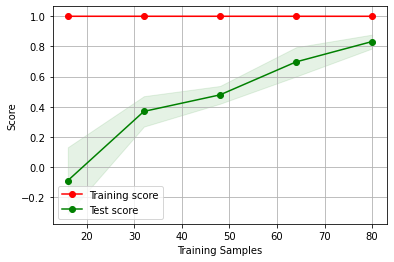

In [9]:
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=100)

sizes, t_scores, v_scores = learning_curve(Ridge(), X, y, train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0])

t_scores_mean = np.mean(t_scores, axis=1)
t_scores_std = np.std(t_scores, axis=1)

v_scores_mean = np.mean(v_scores, axis=1)
v_scores_std = np.std(v_scores, axis=1)

fig, ax = plt.subplots()
plt.plot(sizes, t_scores_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, v_scores_mean, 'o-', color="g",label="Test score")
plt.fill_between(sizes, t_scores_mean - t_scores_std, t_scores_mean + t_scores_std, alpha=0.1, color="r")
plt.fill_between(sizes, v_scores_mean - v_scores_std, v_scores_mean + v_scores_std, alpha=0.1, color="g")
ax.set(xlabel='Training Samples', ylabel='Score')
ax.legend()
ax.grid()
plt.show()

## Hyper-Parameter Optimization
Nearly all estimators have useful arguments that we can change to get better performance, some require these to be tuned to get any good performance at all.  If you look in the documentation you should see there is actually a large amount of arguments for nearly all models, manually trying all of them is not practical.  Sklearn comes with tools to help us tune our models, grid search is a tool that goes through all parameter options, random search is a similar tool that only goes through a percent of the options provided.

After creating a GridSearchCV you need to create a dictionary where each key is a parameter name, and the values are options you would like to try.  GridSearch goes through every possibility, so in the example below the fit will actually happen 20 * 5 times (20 for each alpha and then 5 for each solver).  After being fit you can retrive the best score and parameters, with a large dataset and many different options to try this can be very costly. One way to offset this is to try large "chunky" values first e.g. 0-10, then once you find out the digit try X.0-X.9, and so on until you find a good value.

* Notice the CV at the end of the name, this tool uses cross validation for its calculations so if you want to use something other than the default (KFold) then you will need to specify it as an agrument

In [1]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=100, n_features=1, noise=10)

params = {'alpha':[i for i in range(20)],
          'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']}

grid = GridSearchCV(Ridge(), params)
grid.fit(X, y)
best = grid.best_estimator_.get_params()

print(grid.best_score_)
for arg in params.keys():
    print(f'{arg} - {best[arg]}')

0.9889132795577906
alpha - 0
solver - sag


You can actually use the *get_params* function by itself on any estimator, it can be very useful to save this information out to a file when testing different tunings.

In [5]:
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=100, n_features=1, noise=10)
model = Ridge()
print(model.get_params())

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


# OK
Each time we learn a validation technique we can be more sure of how well our models are performing, if we are not robust with the selection of a model then it will be difficult to tell if we are getting the best predictions that we can.  The process of validating a model is just as import as data processing and modeling.